# Collection & Analysis of Growth Rates in Varying Carbon Sources

© 2019 Zofii Kaczmarek. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import glob
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../../')
import mwc.io
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

## Per-Well Analyses: `deltaLacI` in Glucose

We consider data from running Gaussian processing each well separately.

First we collect and tidy the data. 

In [2]:
# Collect and concat gaussian processing output statistics for accepted experiments
data_dir = '../processing/growth_curves_plate_reader/'
growth_exp = glob.glob(f'{data_dir}*mixedmedia*growth')
growth_dfs = []
for _, d in enumerate(growth_exp):
    sub_exps = glob.glob(f'{d}/output/delta_*/per_well_stats.csv')
    for _, s in enumerate(sub_exps):
        if s != []:
            state = mwc.io.scrape_frontmatter(d)
            if state['status'].lower() == 'accepted':
                growth_df = pd.read_csv(s).drop(columns = 'strain')
                growth_df['date'] = d.split('/')[-1].split('_')[0]
                growth_df['temp_C'] = d.split('/')[-1].split('_')[2][0:2]
                growth_df['carbon'] = s.split('/')[-2].split('_')[1]
                growth_dfs.append(growth_df)
growth_df_pw = pd.concat(growth_dfs)
growth_df_pw['operator'] = 'O2'
#growth_df_pw.to_csv('carbon_quality_analysis/compiled_per_well_stats.csv', index=False)

In [3]:
# # Load the previously compiled dataframe of per-well growth rates.
# growth_df_pw = pd.read_csv('carbon_quality_analysis/compiled_per_well_stats.csv')

In [4]:
# Select the first derivative and standard deviation parameters
growth_rate_df_pw = growth_df_pw[
    (growth_df_pw['parameter'] == 'max df') | (growth_df_pw['parameter'] == 'max df std')].copy().reset_index(drop=True)

# Rename
growth_rate_df_pw.loc[growth_rate_df_pw['parameter'] == 'max df','parameter'] = 'growth_rate'
growth_rate_df_pw.loc[growth_rate_df_pw['parameter'] == 'max df std','parameter'] = 'growth_rate_std'

# Add unique tag to allow pivoting
named = growth_rate_df_pw.copy()
named['date'] = named['date'].astype('str')
named['well_id'] = named['well_id'].astype('str')
named['unique_id'] = named['date']+named['well_id']
# Reshape
wide = named.pivot(index = 'unique_id', columns='parameter', values='value').reset_index()
long = named[['unique_id','temp_C','carbon','operator']].drop_duplicates()
stats_df_pw = pd.merge(long,wide, how='left', on='unique_id').sort_values('unique_id')
# Recover date and well id from unique id
stats_df_pw['date'] = stats_df_pw['unique_id'].str[:-2]
stats_df_pw['well_id'] = stats_df_pw['unique_id'].str[8:]
#stats_df_pw = stats_df_pw.drop(columns = ['unique_id'])

# Calculate doubling times and standard deviations from first derivative
stats_df_pw['doub_time_minutes'] = np.log(2)/stats_df_pw['growth_rate']
stats_df_pw['doub_time_std'] = np.log(2)*stats_df_pw['growth_rate_std']/(stats_df_pw['growth_rate'])**2

# Convert temperatures from strings to ints
stats_df_pw['temp_C'] = stats_df_pw['temp_C'].astype('int')

stats_df_pw = stats_df_pw.sort_values('temp_C')

In [5]:
stats_df_pw.groupby(['carbon', 'temp_C']).mean()

,,growth_rate,growth_rate_std,doub_time_minutes,doub_time_std
carbon,temp_C,,,,
LB,37,0.027473,0.000458,25.311486,0.420340
acetate,37,0.044224,0.008558,201.304598,1.599877
glucose,37,0.010669,0.000148,65.097344,0.877721
glycerol,37,0.006538,0.000036,106.292894,0.577947


### Removal of Pathological Fits

Some wells were fit to pathological derivative curves, with large error regions on the fits. This sometimes led to extremely high or low growth rates.

* 20190124 D9 (45)

In [22]:
stats_df_pw[stats_df_pw['unique_id'].isin(['2019012445'])]

,unique_id,temp_C,carbon,operator,growth_rate,growth_rate_std,date,well_id,doub_time_minutes,doub_time_std
103,2019012445,37,acetate,O2,2.820059,0.588605,20190124,45,0.245792,0.051302


In [55]:
stats_df_pw_filt = stats_df_pw[~stats_df_pw['unique_id'].isin(['2019012445'])].sort_values('doub_time_minutes')

### Per-Well Growth Rates and Model Fit Errors
No averaging or error propogation. Errors from model fits only.

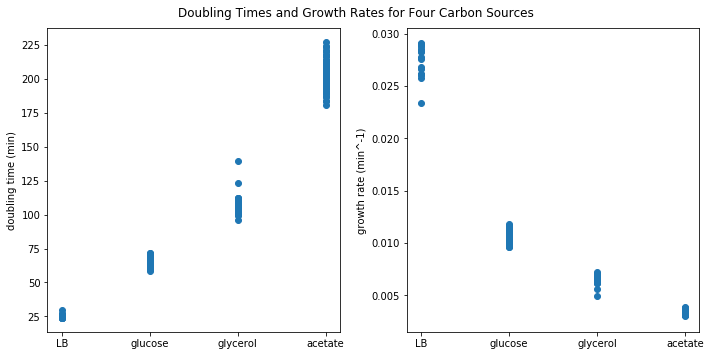

In [115]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

ax[0].scatter(stats_df_pw_filt['carbon'], stats_df_pw_filt['doub_time_minutes'])
ax[1].scatter(stats_df_pw_filt['carbon'], stats_df_pw_filt['growth_rate'])

ax[0].set_ylabel('doubling time (min)')
ax[1].set_ylabel('growth rate (min^-1)')
ax[1].set_ylim(0.0015,0.0305)

plt.tight_layout()
fig.suptitle('Doubling Times and Growth Rates for Four Carbon Sources')
fig.subplots_adjust(top=0.92)

#plt.savefig('carbon_quality_analysis/delta_37_growth_rate_vs_carbon_pw.png')

### Per-Well Mean Growth Rates
Averaged data, no error bars shown.

In [102]:
stats_df_pw_avgd = stats_df_pw_filt.drop(columns = ['growth_rate_std', 'doub_time_std']).groupby(
    ['temp_C','carbon','operator']).agg(['mean','sem','std','count'])
stats_df_pw_avgd.columns = ['_'.join(col) for col in stats_df_pw_avgd.columns.values]
stats_df_pw_avgd = stats_df_pw_avgd.reset_index()
stats_df_pw_avgd = stats_df_pw_avgd.drop(columns = 'growth_rate_count')
stats_df_pw_avgd = stats_df_pw_avgd.rename(columns = {'doub_time_minutes_count':'num_well_replicates'})
stats_df_pw_avgd = stats_df_pw_avgd.sort_values('doub_time_minutes_mean')

In [103]:
stats_df_pw_avgd

,temp_C,carbon,operator,growth_rate_mean,growth_rate_sem,growth_rate_std,doub_time_minutes_mean,doub_time_minutes_sem,doub_time_minutes_std,num_well_replicates
0,37,LB,O2,0.027473,0.000367,0.001556,25.311486,0.361142,1.532197,18
2,37,glucose,O2,0.010669,0.000058,0.000483,65.097344,0.351212,2.938450,70
3,37,glycerol,O2,0.006538,0.000038,0.000321,106.292894,0.697079,5.873690,71
1,37,acetate,O2,0.003403,0.000022,0.000182,204.261345,1.314787,10.842009,68


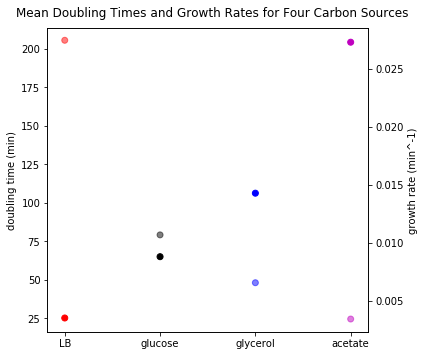

In [116]:
fig, ax1 = plt.subplots(figsize = (6, 5))

ax1.scatter(stats_df_pw_avgd['carbon'], stats_df_pw_avgd['doub_time_minutes_mean'], color = ['r','k','b','m'])

ax2 = ax1.twinx()
ax2.scatter(stats_df_pw_avgd['carbon'], stats_df_pw_avgd['growth_rate_mean'], color = ['r','k','b','m'], alpha = 0.5)
ax2.set_ylim(0.0023,0.0285)

ax1.set_ylabel('doubling time (min)')
ax2.set_ylabel('growth rate (min^-1)')

plt.tight_layout()
fig.suptitle('Mean Doubling Times and Growth Rates for Four Carbon Sources')
fig.subplots_adjust(top=0.92)

#plt.savefig('carbon_quality_analysis/delta_37_growth_rate_vs_carbon_pw_mean.png')

### Per-Well Mean Growth Rates and SEM
Averaged data, with standard errors of the mean, plotted without data point markers to show errors clearly.

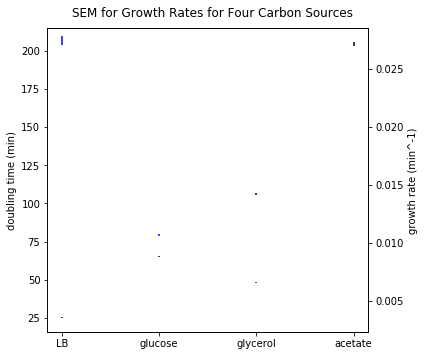

In [118]:
fig, ax1 = plt.subplots(figsize = (6, 5))

ax1.errorbar(stats_df_pw_avgd['carbon'], stats_df_pw_avgd['doub_time_minutes_mean'], 
             yerr = stats_df_pw_avgd['doub_time_minutes_sem'], ls = '', color = 'k')

ax2 = ax1.twinx()
ax2.errorbar(stats_df_pw_avgd['carbon'], stats_df_pw_avgd['growth_rate_mean'], 
             yerr = stats_df_pw_avgd['growth_rate_sem'], ls = '', color = 'b')
ax2.set_ylim(0.0023,0.0285)

ax1.set_ylabel('doubling time (min)')
ax2.set_ylabel('growth rate (min^-1)')

plt.tight_layout()
fig.suptitle('SEM for Growth Rates for Four Carbon Sources')
fig.subplots_adjust(top=0.92)

#plt.savefig('carbon_quality_analysis/delta_37_growth_rate_vs_carbon_pw_sem.png')

### Per-Well Mean Growth Rates and Standard Deviation
Averaged data, plotted with standard devation of replicates.

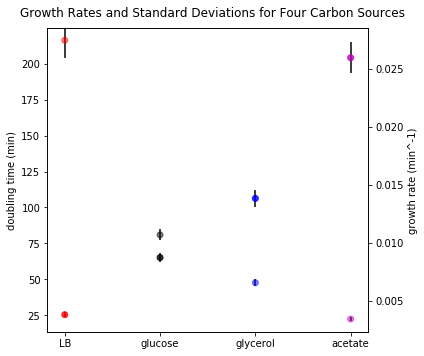

In [119]:
fig, ax1 = plt.subplots(figsize = (6, 5))

ax1.errorbar(stats_df_pw_avgd['carbon'], stats_df_pw_avgd['doub_time_minutes_mean'], 
             yerr = stats_df_pw_avgd['doub_time_minutes_std'], ls='', color = 'k', zorder=0)
ax1.scatter(stats_df_pw_avgd['carbon'], stats_df_pw_avgd['doub_time_minutes_mean'], color=['r','k','b','m'], alpha=0.8)

ax2 = ax1.twinx()
ax2.errorbar(stats_df_pw_avgd['carbon'], stats_df_pw_avgd['growth_rate_mean'], 
             yerr = stats_df_pw_avgd['growth_rate_std'], ls='', color = 'k',zorder=0)
ax2.scatter(stats_df_pw_avgd['carbon'], stats_df_pw_avgd['growth_rate_mean'], color=['r','k','b','m'], alpha=0.5)
ax2.set_ylim(0.0023,0.0285)

ax1.set_ylabel('doubling time (min)')
ax2.set_ylabel('growth rate (min^-1)')

plt.tight_layout()
fig.suptitle('Growth Rates and Standard Deviations for Four Carbon Sources')
fig.subplots_adjust(top=0.92)

#plt.savefig('carbon_quality_analysis/delta_37_growth_rate_vs_carbon_pw_std.png')

And finally, let's look at the numbers for growth rates at each temperature.

In [99]:
stats_df_pw_avgd

,temp_C,carbon,operator,growth_rate_mean,growth_rate_sem,growth_rate_std,doub_time_minutes_mean,doub_time_minutes_sem,doub_time_minutes_std
0,37,LB,O2,0.027473,0.000367,0.001556,25.311486,0.361142,1.532197
2,37,glucose,O2,0.010669,0.000058,0.000483,65.097344,0.351212,2.938450
3,37,glycerol,O2,0.006538,0.000038,0.000321,106.292894,0.697079,5.873690
1,37,acetate,O2,0.003403,0.000022,0.000182,204.261345,1.314787,10.842009


In [104]:
stats_df_pw_avgd['growth_rate_mean']*60

0    1.648406
2    0.640159
3    0.392307
1    0.204177
Name: growth_rate_mean, dtype: float64